# Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
from arch.unitroot import ADF
import yfinance
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [ ]:
raw_data = yfinance.download(tickers = 'VOW3.DE, PAH3.DE, BMW.DE', interval = '1d', group_by = 'ticker', auto_adjust = True)
df = raw_data.copy()

[*********************100%%**********************]  3 of 3 completed


# Key Dates

In [ ]:
start_date = '2009-01-05'

#First official announcement
ann_1 = '2009-12-09'

#second official announcement
ann_2 = '2012-07-05'

#Ending Date
end_date = '2014-01-01'

#Diesel Gate
d_gate = '2015-09-20'

# Pre-procesing

In [ ]:
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

#Returns
df['ret_vol'] = df['vol'].pct_change(1)*100
df['ret_por'] = df['por'].pct_change(1)*100
df['ret_bmw'] = df['bmw'].pct_change(1)*100

#Squared Returns
df['sq_vol'] = df['ret_vol']**2
df['sq_por'] = df['ret_por']**2
df['sq_bmw'] = df['ret_bmw']**2

#Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

del df['PAH3.DE']
del df['VOW3.DE']
del df['BMW.DE']

In [ ]:
#Assigning frequency and missing values
df = df.asfreq('b')
df.fillna(method ='bfill',inplace = True)

# Plotting the Prices

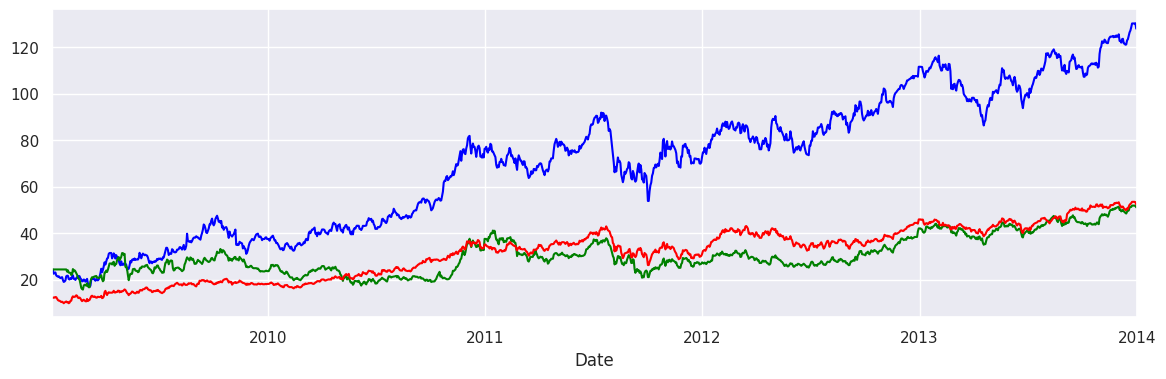

In [ ]:
df['vol'][start_date:end_date].plot(figsize = (14, 4), color ='blue')
df['por'][start_date:end_date].plot(color = 'green')
df['bmw'][start_date:end_date].plot(color = 'red')
plt.show()

# Checking prices for Stationarity

In [ ]:
for car in df.columns[0:3]:
  adf = ADF(df[car])
  print(adf.summary().as_text())
  print()                          #We fail to reject the null for each of the three company's stock price, i.e all three of them has a unit root.

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.403
P-value                         0.581
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.999
P-value                         0.287
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.456
P-value                         0.900
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)


# Plotting Returns

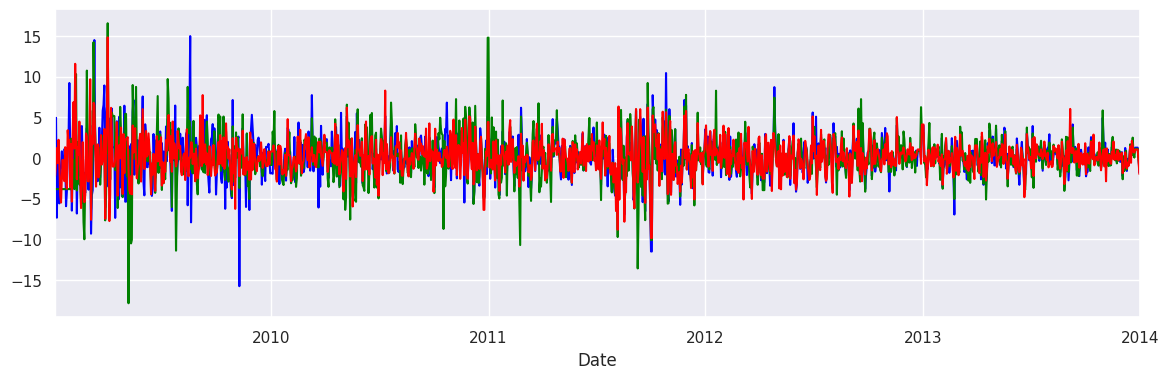

In [ ]:
df['ret_vol'][start_date:end_date].plot(figsize = (14, 4), color ='blue')
df['ret_por'][start_date:end_date].plot(color = 'green')
df['ret_bmw'][start_date:end_date].plot(color = 'red')
plt.show()

# Checking returns for Stationarity

In [ ]:
for car in df.columns[3:6]:
  adf = ADF(df[car])
  print(adf.summary().as_text())
  print()                                      #Returns seem to be stationary with Test Statistic of porsche being very close to the 5% critical value.

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.802
P-value                         0.000
Lags                               35
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.523
P-value                         0.110
Lags                               31
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

   Augmented Dickey-Fuller Results   
Test Statistic                -14.782
P-value                         0.000
Lags                               32
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)


In [ ]:
df.tail().index[-1]

Timestamp('2024-01-16 00:00:00', freq='B')

# Plotting Prices after the Dieselgate incident

Volkswagen had the biggest fall, followed by Porsche. BMW dropped but later bounced back while Volkswagen and Porsche still struggled.

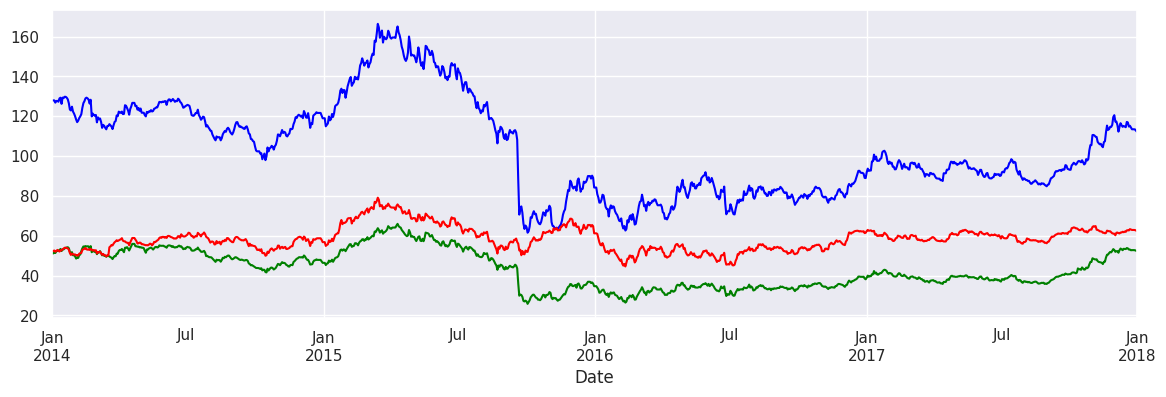

In [ ]:
date = '2018-01-01'
df['vol'][end_date:date].plot(figsize = (14, 4), color ='blue')
df['por'][end_date:date].plot(color = 'green')
df['bmw'][end_date:date].plot(color = 'red')
plt.show()

# Correlations

In [ ]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-01-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8415627445416405
Volkswagen and BMW correlation: 	0.9826886179907053
Porsche and BMW correlation: 		0.8122439013211441


In [ ]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-01-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.7960242468827381
Volkswagen and BMW correlation: 	0.9256438567726277
Porsche and BMW correlation: 		0.7572697623202153


In [ ]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7428268339595308
Volkswagen and BMW correlation: 	0.9795943044355954
Porsche and BMW correlation: 		0.7042723645426862


In [ ]:
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405237404484882
Volkswagen and BMW correlation: 	0.9284447525491649
Porsche and BMW correlation: 		0.9494111599581522


In [ ]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2024-01-16 00:00:00

Volkswagen and Porsche correlation: 	0.8809757763007421
Volkswagen and BMW correlation: 	0.4409488759360739
Porsche and BMW correlation: 		0.43307862222284715


# Finding the Best Fit Model for each time period

##For Volkswagen

In [ ]:
mod_pre_vol = auto_arima(df.vol[start_date:ann_1], X = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_btn_vol = auto_arima(df.vol[ann_1:ann_2], X = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_post_vol = auto_arima(df.vol[ann_2:end_date], X = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)
mod_dg_vol = auto_arima(df.vol[d_gate:date], X = df[['por','bmw']][d_gate:date],
                            m = 5, max_p = 5, max_q = 5)

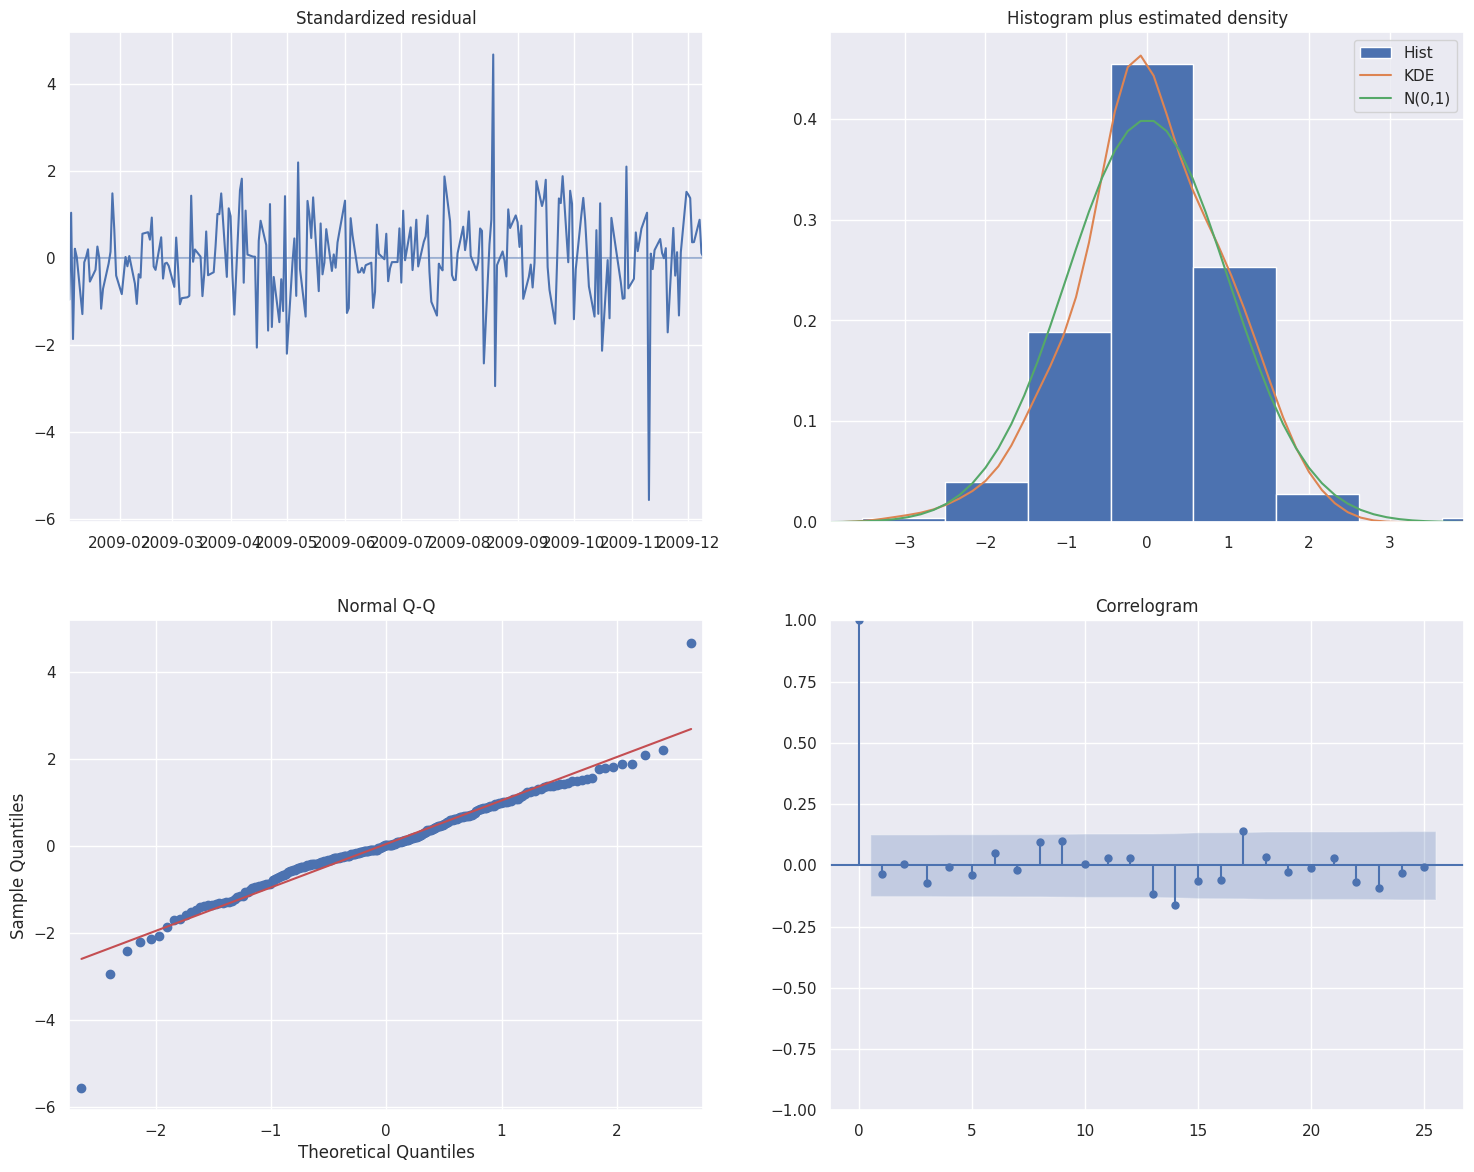

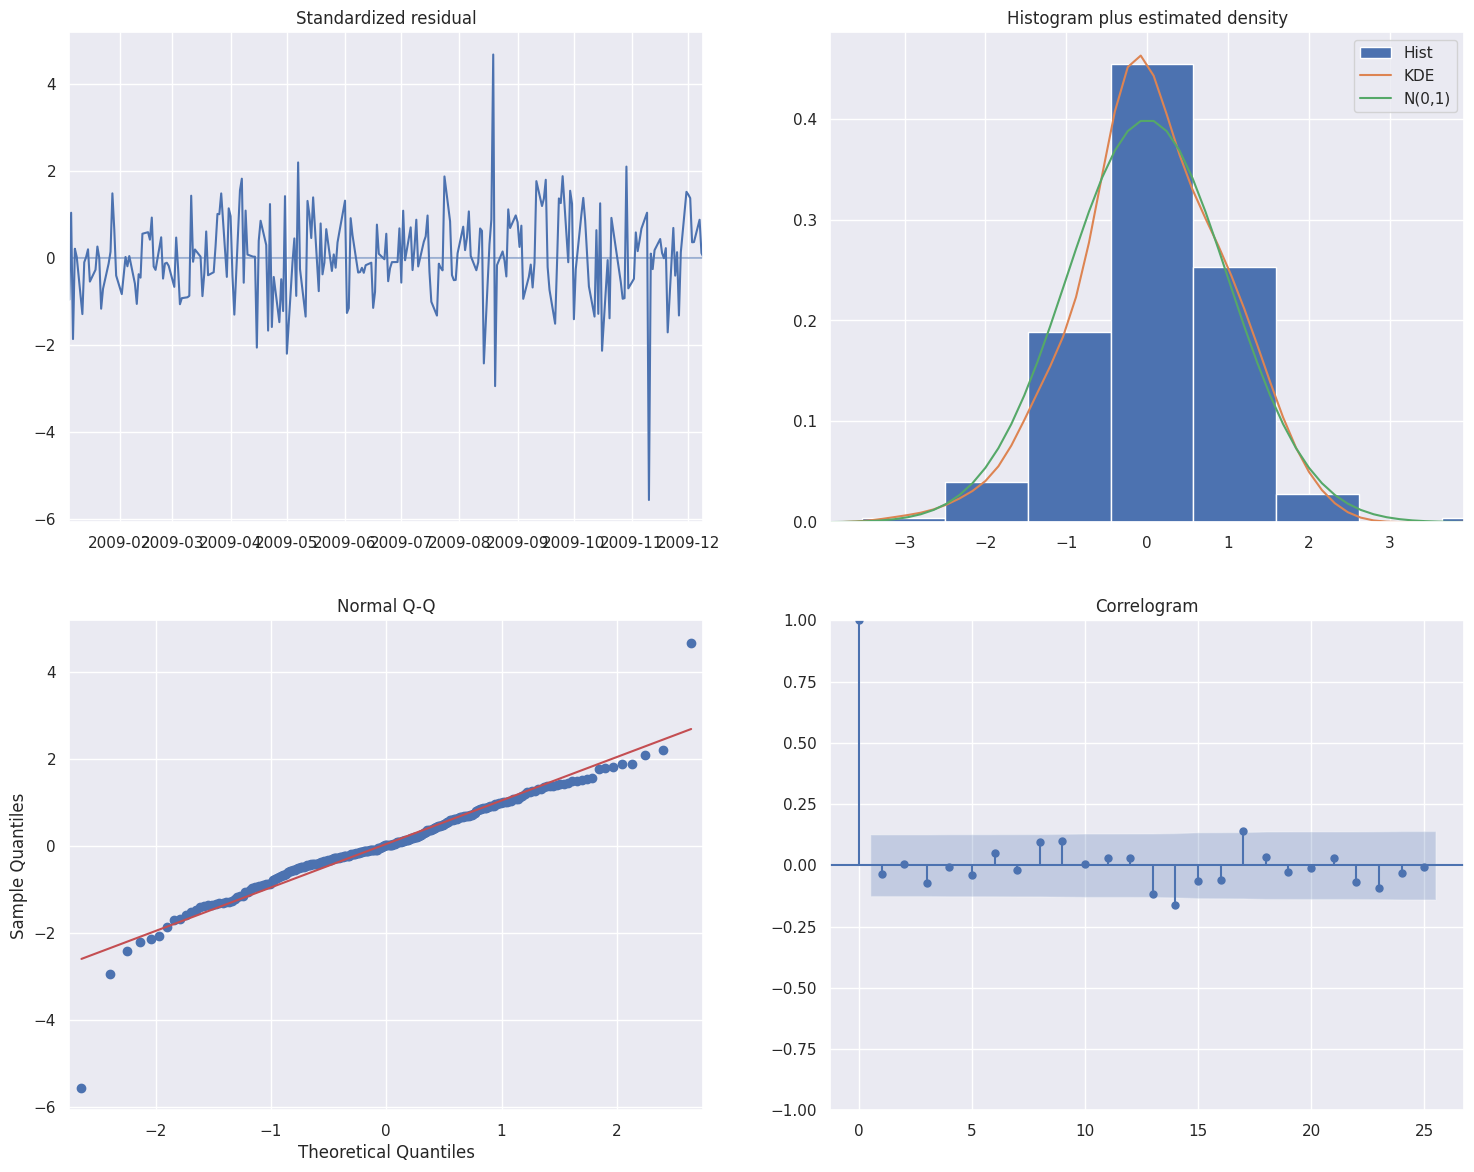

In [ ]:
mod_pre_vol.plot_diagnostics(figsize = (18, 14), lags =25)

In [ ]:
print(mod_pre_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -356.222
Date:                Tue, 16 Jan 2024   AIC                            722.443
Time:                        15:19:59   BIC                            739.908
Sample:                    01-05-2009   HQIC                           729.478
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2587      0.202      1.283      0.200      -0.137       0.654
por            0.3350      0.062      5.401      0.000       0.213       0.457
bmw            0.5603      0.201      2.792      0.0

In [ ]:
print(mod_btn_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -895.517
Date:                Tue, 16 Jan 2024   AIC                           1797.035
Time:                        15:21:03   BIC                           1810.561
Sample:                    12-09-2009   HQIC                          1802.274
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.6518      0.051     12.842      0.000       0.552       0.751
bmw            1.3413      0.063     21.268      0.000       1.218       1.465
sigma2         0.8448      0.034     24.532      0.0

In [ ]:
print(mod_post_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -500.793
Date:                Tue, 16 Jan 2024   AIC                           1007.587
Time:                        15:21:43   BIC                           1019.478
Sample:                    07-05-2012   HQIC                          1012.301
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.4167      0.047     30.369      0.000       1.325       1.508
bmw            0.7427      0.079      9.381      0.000       0.588       0.898
sigma2         0.7687      0.038     20.461      0.0

In [ ]:
print(mod_dg_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  596
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -644.318
Date:                Tue, 16 Jan 2024   AIC                           1302.635
Time:                        15:25:28   BIC                           1333.355
Sample:                    09-21-2015   HQIC                          1314.599
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            2.2922      0.029     79.119      0.000       2.235       2.349
bmw            0.0976      0.036      2.707      0.007       0.027       0.168
ar.L1          1.5405      0.113     13.636      0.0

#Volatility

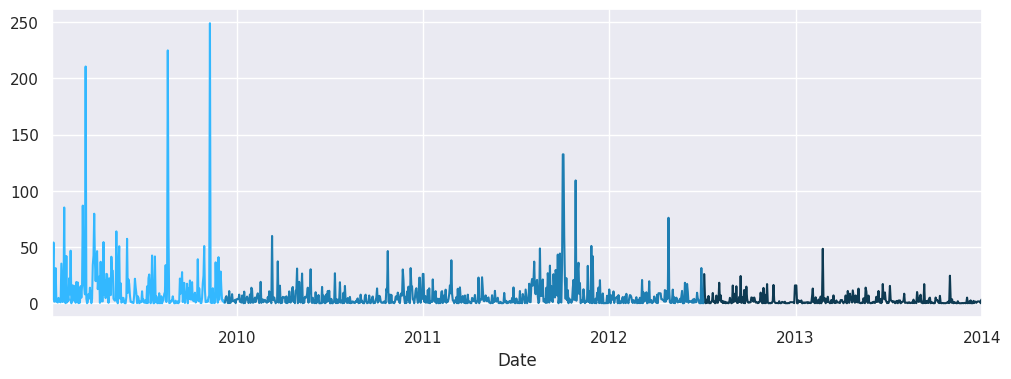

In [ ]:
df['sq_vol'][start_date:ann_1].plot(figsize = (12, 4), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()                                             #There is a clear jump in volatility around the 2 announcement dates(both before and after the announcement)

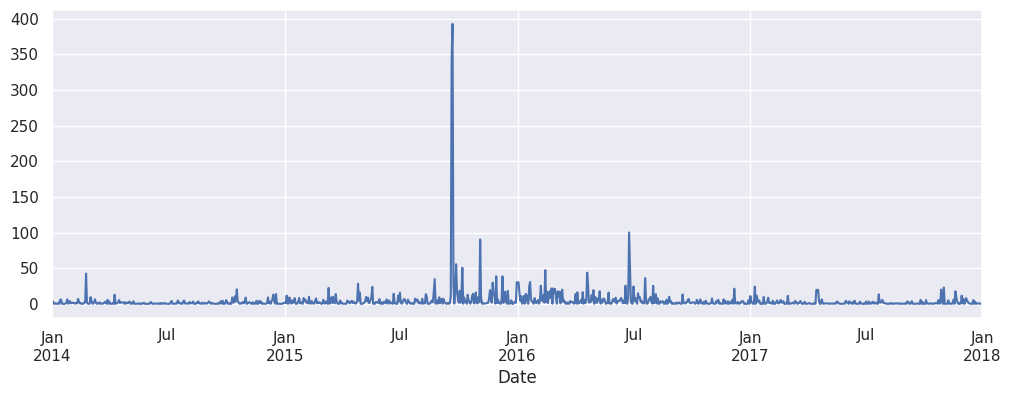

In [ ]:
df['sq_vol'][end_date:date].plot(figsize = (12, 4))
plt.show()                                          #There is a clear jump in volatility around 2015 when the dieselgate incident occured.

#Fitting a Simple GARCH Model to different time periods

In [ ]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

model_garch_dg = arch_model(df.ret_vol[end_date:date], mean = "AR",  vol = "GARCH", p = 2, q = 2)
results_garch_dg = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 665.6686688440825
Iteration:     10,   Func. Count:     56,   Neg. LLF: 665.1877229818735
Iteration:     15,   Func. Count:     81,   Neg. LLF: 665.1832754541216
Optimization terminated successfully    (Exit mode 0)
            Current function value: 665.1832754541216
            Iterations: 16
            Function evaluations: 85
            Gradient evaluations: 16
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.753622223493
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.7316909208432
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.7316909195988
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5619792512794
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5576343732475
            Iterations: 7
            Fu

In [ ]:
print(results_garch_btn.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Tue, Jan 16 2024   Df Residuals:                      671
Time:                        16:15:54   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-0

In [ ]:
print(results_garch_pre.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -665.183
Distribution:                  Normal   AIC:                           1338.37
Method:            Maximum Likelihood   BIC:                           1352.34
                                        No. Observations:                  243
Date:                Tue, Jan 16 2024   Df Residuals:                      242
Time:                        16:15:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1676      0.247      0.678      0.498 [ -0.317,  0.65

In [ ]:
print(results_garch_post.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Tue, Jan 16 2024   Df Residuals:                      389
Time:                        16:15:54   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-0

In [ ]:
print(results_garch_dg.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Tue, Jan 16 2024   Df Residuals:                      389
Time:                        16:18:02   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-0